_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Ziwei Huang

Summer term 2021

Names: *Nishad Singhi (5619175) | Harry Antony (5610172)*

# Coding Lab 8

In this exercise we are going to fit a latent variable model (Poisson GPFA) to both toy data and real data from monkey primary visual cortex.

## Preliminaries

1. Clone the poisson-GPFA repository from https://github.com/mackelab/poisson-gpfa and make sure that you have a directory ```../funs/```  in the folder with this notebook. The toolbox contains an implementation of the EM algorithm to fit the poisson-gpfa. For the desciption of the algorithm please refer to https://hooram.xyz/projects.html 

2. Download the data file ```nda_ex_8_data.mat``` from ILIAS and save it in a subfolder ```../data/```.

In [193]:
import seaborn as sns
import funs.util as util
import funs.engine as engine
import matplotlib.pyplot as plt
import numpy as np
import datamanager
import scipy.io as sio
import numpy as np
import matplotlib.gridspec as gridspec
import pdb
import numpy.matlib
from statsmodels.stats.moment_helpers import cov2corr

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('paper')
sns.set(rc={'image.cmap': 'bwr'})
% matplotlib inline

UsageError: Line magic function `%` not found.


## Task 1. Generate some toy data to test the poisson-GPFA code

We start by verifying our code on toy data. The cell below contains code to generate data for 30 neurons, 100 trials (1000 ms each) and 50ms bin size. The neurons' firing rate $\lambda_k$ is assumed to be a constant $d_k$ modulated by a one-dimensional latent state $x$, which is drawn from a Gaussian process:

$\lambda_k = \exp(c_kx + d_k)$

Each neuron's weight $c_k$ is drawn randomly from a normal distribution and spike counts are sampled form a Poisson distribution with rate $\lambda_k$.

Your task is to fit a Poisson GPFA model with one latent variable to this data (see `engine.PPGPFAfit`).

*Grading: 3 pts*

In [194]:
# Initialize random number generator
#np.random.seed(10)
# Specify dataset & fitting parameters
xdim      =1#latent dimensionality to fit
ydim      = 30		 #number of neurons in the dataset
numTrials = 100		
trialDur  = 1000 # in ms
binSize   = 50	 # in ms
maxEMiter = 100		
dOffset   = 1.5	 # controls firing rate

# Sample from the model (make a toy dataset)
training_set  = util.dataset(
    seed      =345533,
    xdim      = xdim,
	ydim      = ydim,
	numTrials = numTrials,
	trialDur  = trialDur,
	binSize   = binSize,
	dOffset   = dOffset,
	fixTau 	  = True, 
	fixedTau  = np.array([0.2]),
	drawSameX = False) 

+------------- Simulated Dataset Options -------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                 1000 | Duration of trials (ms):
                                                   50 | Size of bins (ms):
                                                  100 | Number of Trials
+-----------------------------------------------------+
Sampling trial 100 ...
Average firing rate per neuron in this dataset: 46.415 Hz.


### Fit the model

In [195]:
# Initialize parameters using Poisson-PCA
initParams = util.initializeParams(xdim, ydim, training_set)

# fit the model
fitToy = engine.PPGPFAfit(
    experiment = training_set,
    initParams = initParams,
    maxEMiter = maxEMiter,
    EMmode = 'Batch',
    onlineParamUpdateMethod = 'laplace'
)

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                  100 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration: 100 of 100, nPLL: = 13.7852
This dataset is a simulated dataset.
Processing performance against ground truth parameters...


In [196]:
#some useful functions
def allTrialsState(fit,p):
    """Reshape the latent signal and the spike counts"""
    x = np.zeros([p,0])
    for i in range(len(fit.infRes['post_mean'])):
        x = np.concatenate((x,fit.infRes['post_mean'][i]),axis=1)
    return x

def allTrialsX(training_set):
    """Reshape the ground truth 
    latent signal and the spike counts"""
    x_gt = np.array([])
    for i in range(len(training_set.data)):
        x_gt =  np.concatenate((x_gt,training_set.data[i]['X'][0]),axis = 0)
    return x_gt

### Plot the ground truth vs. inferred model
Verify your fit by plotting both ground truth and inferred parameters for:
1. weights C
2. biases d
3. latent state x 

Note that the sign of fitted latent state and its weights are ambiguous (you can flip both without changing the model). Make sure you correct the sign for the plot if it does not match the ground truth.

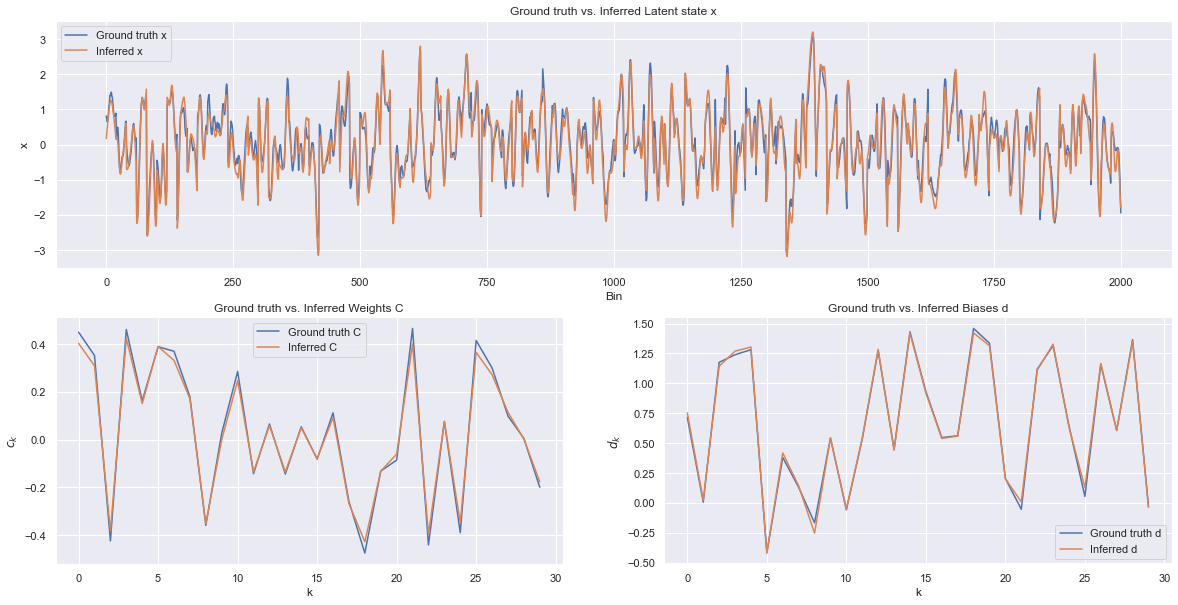

In [197]:
# All trials latent state vector
x = allTrialsState(fitToy,1)
x_gt = allTrialsX(training_set)

# fill in plot here
plt.figure(figsize=(20, 10))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.plot(x_gt.flatten(), label='Ground truth x')
ax1.plot(-1*x.flatten(), label='Inferred x')
ax1.set_title("Ground truth vs. Inferred Latent state x")
ax1.set_xlabel("Bin")
ax1.set_ylabel("x")
ax1.legend()

ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.plot(training_set.params['C'], label='Ground truth C')
ax2.plot(-1*fitToy.optimParams['C'], label='Inferred C')
ax2.set_title("Ground truth vs. Inferred Weights C")
ax2.set_xlabel("k")
ax2.set_ylabel(r"$c_k$")
ax2.legend()

ax3 = plt.subplot2grid((2, 2), (1, 1))
ax3.plot(training_set.params['d'], label='Ground truth d')
ax3.plot(fitToy.optimParams['d'], label='Inferred d')
ax3.set_title("Ground truth vs. Inferred Biases d")
ax3.set_xlabel("k")
ax3.set_ylabel(r"$d_k$")
ax3.legend()

## Task 2: Fit GPFA model to real data. 

We now fit the model to real data and cross-validate over the dimensionality of the latent variable.

*Grading: 2 pts*



### Load data

The cell below implements loading the data and encapsulates it into a class that matches the interface of the Poisson GPFA engine. You don't need to do anything here.

In [198]:
class EckerDataset():
    """Loosy class"""
    def __init__(
        self,
        path = 'data/task8_data.mat',
        subject_id=0,
        ydim = 55,
        trialDur = 400,
        binSize = 20,
        numTrials = 100,
        ydimData = False,
        numTrData = True):
        
        T = binSize#int(trialDur/binSize)
        matdat = sio.loadmat(path)
        self.matdat = matdat
        data = []
        trial_durs = []
        for trial_id in range(numTrials):
            trial_time =matdat['spikeTimes'][:,trial_id][0] 
            trial_big_time = np.min(trial_time)
            trial_end_time = np.max(trial_time)
            trial_durs.append(trial_end_time - trial_big_time)         
        for trial_id in range(numTrials):
            Y = []
            spike_time = []
            data.append({
                'Y': matdat['spikeCounts'][:,:,trial_id],
                'spike_time': matdat['spikeTimes'][:,trial_id]})
        self.T = T
        self.trial_durs = trial_durs    
        self.data = data
        self.trialDur = trialDur
        self.binSize = binSize
        self.numTrials = numTrials
        self.ydim = ydim              
        util.dataset.getMeanAndVariance(self)
        util.dataset.getAvgFiringRate(self)
        util.dataset.getAllRaster(self)

In [199]:
path = '../data/nda_ex_8_data.mat'
data = EckerDataset(path)

### Fit Poisson GPFA models and perform model comparison

Split the data into 80 trials used for training and 20 trials held out for performing model comparison. On the training set, fit models using one to five latent variables. Compute the performance of each model on the held-out test set.

Hint: You can use the `crossValidation` function in the Poisson GPFA package.

Optional: The `crossValidation` function computes the mean-squared error on the test set, which is not ideal. The predictive log-likelihood under the Poisson model would be a better measure, which you are welcome to compute instead.

In [228]:
numTrainingTrials = 80
numTestTrials = 20

In [229]:
cv = util.crossValidation(experiment=data, numTrainingTrials=numTrainingTrials, numTestTrials=numTestTrials, maxXdim=5, maxEMiter=maxEMiter, batchSize=numTrainingTrials, learningMethod='grad')


Assessing optimal latent dimensionality will take a long time.
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                               Online | EM mode:
                                                  100 | Max EM iterations:
                                              laplace | Inference Method
                                               `grad` | Online Param Update Method
                                                   80 | Batch size (trials):
+-----------------------------------------------------+
Iteration: 100 of 100, nPLL: = -392.3490Performing leave-one-out cross validation...
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                     

In [249]:
training_data = np.array([x['Y'] for x in data.data[:numTrainingTrials]])
test_data = np.array([x['Y'] for x in data.data[numTrainingTrials:numTrainingTrials+numTestTrials]])

mean_Y_training = np.mean(np.mean(training_data, axis=0), axis=1)

model_0LV_predictions = np.zeros(test_data.shape)

for i in range(test_data.shape[0]):
    for j in range(test_data.shape[1]):
        for k in range(test_data.shape[2]):
            model_0LV_predictions[i, j, k] = mean_Y_training[j]
            
MSE_0LV = np.sum(np.square(test_data - model_0LV_predictions))

In [252]:
print(model_0LV_predictions[0, :, 0])

[1.605625 2.481875 2.2075   2.635    0.684375 0.12     1.196875 0.290625
 0.145    0.415    0.321875 0.508125 1.7075   1.50125  6.65875  0.116875
 0.081875 0.105625 0.05125  0.07     0.125625 1.74375  0.525625 0.235
 0.408125 0.446875 1.553125 0.5375   1.284375 1.256875 0.363125 0.661875
 0.161875 0.124375 1.3375   0.139375 2.57125  1.669375 1.1025   0.063125
 0.816875 3.77375  1.840625 0.16     1.978125 0.085625 4.745625 1.348125
 0.36375  0.134375 0.7325   0.0625   0.11125  1.028125 0.385   ]


### Plot the test error

Make a plot of the test error for the five different models. As a baseline, please also include the test error of a model without a latent variable. This is essentially the mean-squared error of a constant rate model (or Poisson likelihood if you did the optional part above).

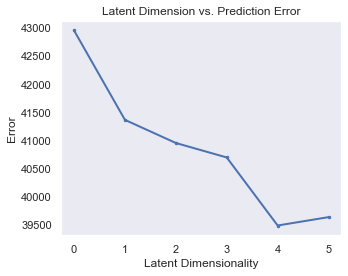

In [250]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(0,cv.maxXdim+1),np.concatenate(([MSE_0LV], cv.errs)),'b.-',markersize=5,linewidth=2)
plt.xlabel('Latent Dimensionality')
plt.ylabel('Error')
plt.title('Latent Dimension vs. Prediction Error')
plt.grid(which='both')
plt.tight_layout()

## Task 3. Visualization: population rasters and latent state. Use the model with a single latent state. 

Create a raster plot where you show for each trial the spikes of all neurons as well as the trajectory of the latent state `x` (take care of the correct time axis). Sort the neurons by their weights `c_k`. Plot only the first 20 trials.

*Grading: 2 pts*

In [236]:
initParams = util.initializeParams(1, data.ydim, data)

# fit the model
model_1LV = engine.PPGPFAfit(
    experiment = data,
    initParams = initParams,
    maxEMiter = maxEMiter,
    EMmode = 'Batch',
    onlineParamUpdateMethod = 'laplace'
)

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                  100 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration: 100 of 100, nPLL: = -379.5649

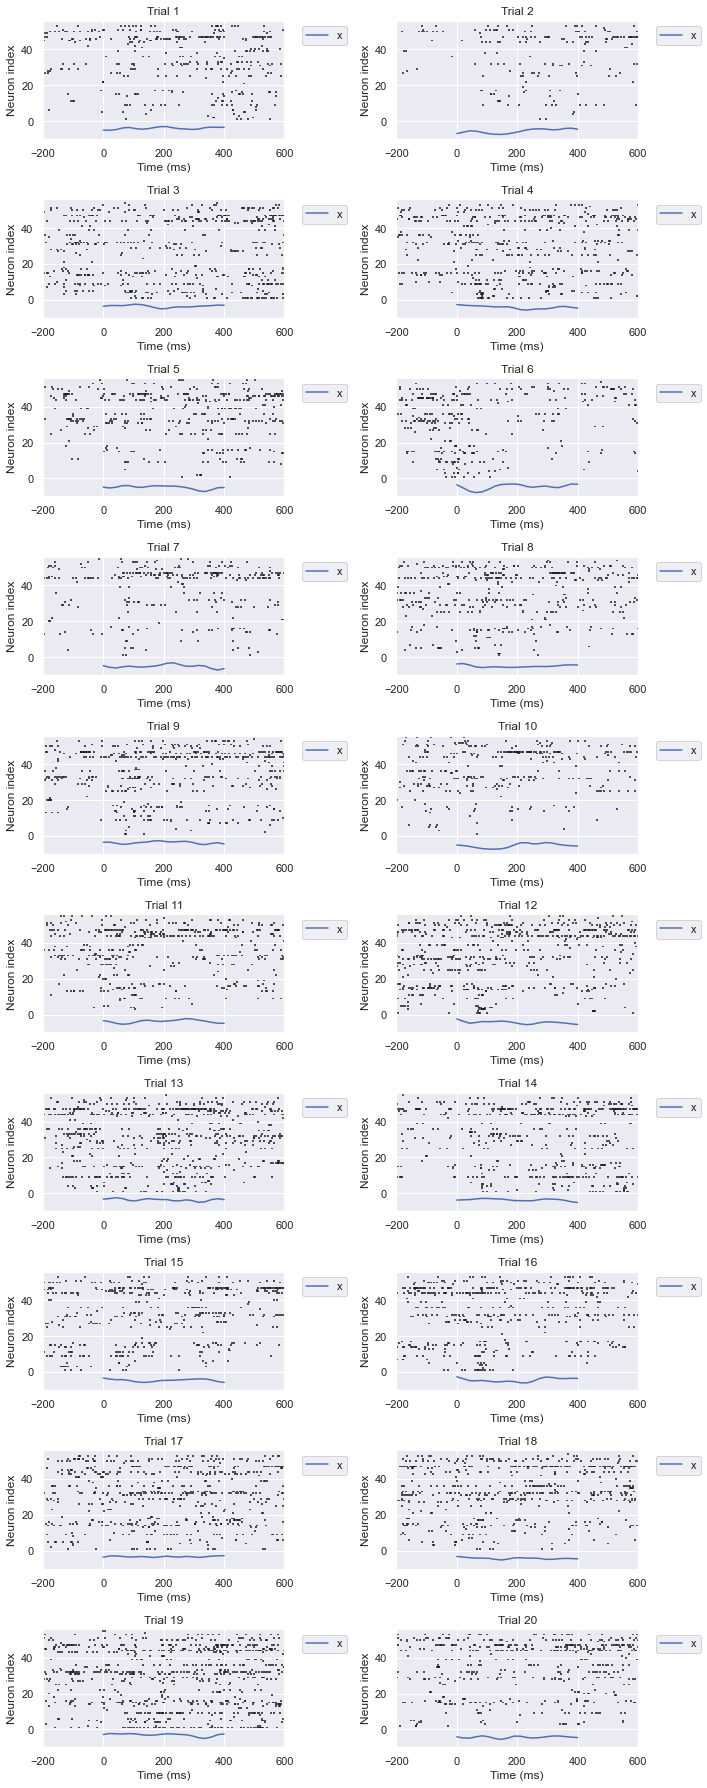

In [237]:
# sort neurons by (the magnitudes of) their weights
C_k = model_1LV.optimParams['C']
sorting_idx = np.argsort(np.abs(C_k.flatten()))[::-1]

# trajectories
x = allTrialsState(model_1LV, 1).flatten()
num_bins = data.trialDur // data.binSize

# extract spike times between -200 ms and 600 ms and plot
num_neurons = data.ydim
num_trials_to_plot = 20

plt.figure(figsize=(10,25))

for trial, trial_data in enumerate(data.data[:num_trials_to_plot]):
    trial_spike_times = trial_data['spike_time']
    trial_spike_times_sorted = trial_spike_times[sorting_idx]
    
    ax = plt.subplot(10, 2, trial+1)
    util.raster(trial_spike_times_sorted)
    p = ax.plot(np.linspace(0, data.trialDur, num_bins), x[trial*num_bins:(trial+1)*num_bins]-5, label='x')
    
    ax.set_xlim(-200, 600)
    ax.set_ylim(-10, 56)
    ax.set_title(f"Trial {trial+1}")
    ax.set_ylabel("Neuron index")
    ax.set_xlabel("Time (ms)")
    ax.legend(handles=p, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Task 4. Visualization of covariance matrix.

Plot (a) the covariance matrix of the observed data as well as its approximation using (b) one and (c) five latent variable(s). Use the analytical solution for the covariance matrix of the approximation*. Note that the solution is essentially the mean and covariance of the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

$ \mu = \exp(\frac{1}{2} \text{ diag}(CC^T)+d)$

$ \text{Cov}= \mu\mu^T \exp(CC^T)+\text{ diag}(\mu) - \mu\mu^T$ 

*[Krumin, M., and Shoham, S. (2009). Generation of Spike Trains with Controlled Auto- and Cross-Correlation Functions. Neural Computation 21, 1642–1664](http://www.mitpressjournals.org/doi/10.1162/neco.2009.08-08-847).

*Grading: 3 pts*

In [238]:
def mu(C,d):
    return np.exp((1/2)*np.diag(C@(C.T))+d)

def noise_cov_approx(C,d):
    mean = mu(C,d)
    return np.outer(mean,mean) * np.exp(C@(C.T))+ np.diag(mean)  - np.outer(mean,mean.T)

def noise_cov_approx_from_model(model):
    C = model.optimParams['C']
    d = model.optimParams['d']
        
    return noise_cov_approx(C, d)

In [239]:
initParams = util.initializeParams(5, data.ydim, data)

# fit the model
model_5LV = engine.PPGPFAfit(
    experiment = data,
    initParams = initParams,
    maxEMiter = maxEMiter,
    EMmode = 'Batch',
    onlineParamUpdateMethod = 'laplace'
)

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    5 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                  100 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration: 100 of 100, nPLL: = -311.8017

Text(0.5, 1.0, 'Covariance matrix of model with \n5 latent variables')

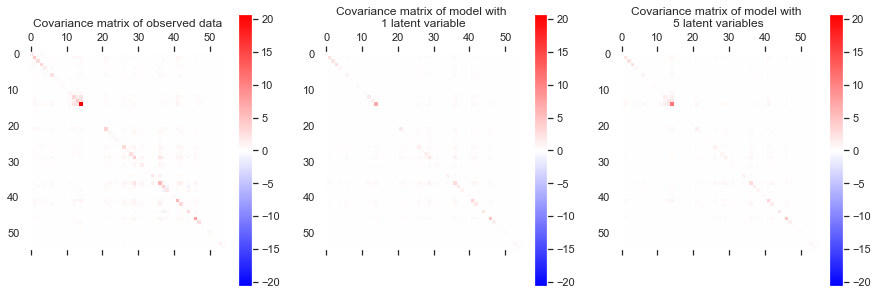

In [253]:
observed_cov = np.cov(model_1LV.experiment.all_raster)
model_1LV_cov = noise_cov_approx_from_model(model_1LV)
model_5LV_cov = noise_cov_approx_from_model(model_5LV)

max_abs_value = np.max((np.max(np.abs(observed_cov)), np.max(np.abs(model_1LV_cov)), np.max(np.abs(model_5LV_cov))))

fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 3, 1)
i1 = ax1.matshow(observed_cov, vmin=-max_abs_value, vmax=max_abs_value)
plt.colorbar(i1)
ax1.set_title("Covariance matrix of observed data")

ax2 = plt.subplot(1, 3, 2)
i2 = ax2.matshow(model_1LV_cov, vmin=-max_abs_value, vmax=max_abs_value)
plt.colorbar(i2)
ax2.set_title("Covariance matrix of model with \n1 latent variable")

ax3 = plt.subplot(1, 3, 3)
i3 = ax3.matshow(model_5LV_cov, vmin=-max_abs_value, vmax=max_abs_value)
plt.colorbar(i3)
ax3.set_title("Covariance matrix of model with \n5 latent variables")